In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import fnmatch
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from sklearn.manifold import TSNE
import json

In [3]:
def get_features(y, sr):
    # y = y[0:sr]  # analyze just first second
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    centroid = librosa.feature.spectral_centroid(y, sr)
    centroid = np.mean(centroid)
    bandwidth = librosa.feature.spectral_bandwidth(y,sr)
    bandwidth = np.mean(bandwidth)
    contrast = librosa.feature.spectral_contrast(y,sr)
    contrast = np.mean(contrast)
    flatness = librosa.feature.spectral_flatness(y)
    flatness = np.mean(flatness)
    feature_vector = [centroid, bandwidth, contrast, flatness]
    # mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    # delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    # delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    # feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    # feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector

In [4]:
source_audio = "D:/Yanni/YanniBestOf/daily_download_20170213_128.mp3"

In [79]:
hop_length = 512
y, sr = librosa.load(source_audio)


In [6]:

onset_strengths = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)


In [7]:
onsets = [0]
local_min_index = 0
sensitivity = 30
min_length = 30
for index in range(sensitivity, len(onset_strengths) - sensitivity):
    local_max = np.amax(onset_strengths[index-sensitivity: index])
    
    if onset_strengths[index-1] > onset_strengths[index] < onset_strengths[index+1]:
        local_min_index = index
    if onset_strengths[index] > local_max and not onsets[-1] == local_min_index:
        onsets.append(local_min_index)
        if (onsets[-1] - onsets[-2]) < min_length:
            onsets.pop(-2)

times = [hop_length * onset / sr for onset in onsets]

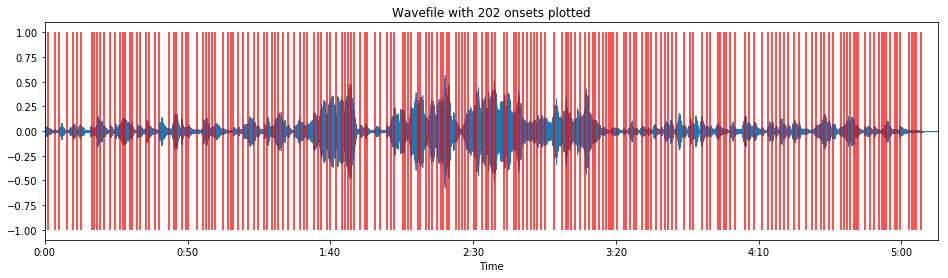

In [8]:
plt.figure(figsize=(16,4))
plt.subplot(1, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.vlines(times, -1, 1, color='r', alpha=0.9, label='Onsets')
plt.title('Wavefile with %d onsets plotted' % len(times))
plt.show()

In [9]:
len(onsets)

202

In [10]:
feature_vectors = []
centroids = []
bandwidths = []
contrasts = []
flatnesses = []
all_features = []
for i in range(len(onsets)-1):
    idx_y1 = onsets[i  ]*hop_length
    idx_y2 = onsets[i+1]*hop_length
    y_interval = y[idx_y1:idx_y2]
    features = get_features(y_interval, sr)
    centroids.append(features[0])
    bandwidths.append(features[1])
    contrasts.append(features[2])
    flatnesses.append(features[3])
    
    feature_vectors.append({'index':idx_y1, "endIndex":idx_y2, "features":features})
    if i % 50 == 0:
        print(f"analyzed {i+1}/{len(onsets)-1} = {idx_y1}")

centroids = (centroids-np.mean(centroids)) / np.std(centroids)
bandwidths = (bandwidths-np.mean(bandwidths)) / np.std(bandwidths)
contrasts = (contrasts-np.mean(contrasts)) / np.std(contrasts)
flatnesses = (flatnesses-np.mean(flatnesses)) / np.std(flatnesses)

for i in range(len(onsets)-1):
    idx_y1 = onsets[i  ]*hop_length
    idx_y2 = onsets[i+1]*hop_length
    features = [centroids[i], bandwidths[i], contrasts[i], flatnesses[i]]
    all_features.append(features)
    feature_vectors.append({'index':idx_y1, "endIndex":idx_y2, "features":features})


analyzed 1/201 = 0
analyzed 51/201 = 1781248
analyzed 101/201 = 3424256
analyzed 151/201 = 5005312
analyzed 201/201 = 6731264


In [94]:
features_matrix = [f["features"] for f in feature_vectors]

model = TSNE(n_components=2, learning_rate=10, perplexity=5, verbose=2, angle=0.1).fit_transform(features_matrix)

x_axis, y_axis = model[:,0], model[:,1]
x_norm = (x_axis - np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

data = [{"index":f['index'], "endIndex":f['endIndex'], "point":[float(x), float(y)]} for f, x, y, in zip(feature_vectors, x_norm, y_norm)]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 402 samples in 0.000s...
[t-SNE] Computed neighbors for 402 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 402 / 402
[t-SNE] Mean sigma: 0.349153
[t-SNE] Computed conditional probabilities in 0.007s
[t-SNE] Iteration 50: error = 77.2047348, gradient norm = 0.1642584 (50 iterations in 0.242s)
[t-SNE] Iteration 100: error = 63.1511574, gradient norm = 0.0380730 (50 iterations in 0.169s)
[t-SNE] Iteration 150: error = 60.5503693, gradient norm = 0.0184829 (50 iterations in 0.164s)
[t-SNE] Iteration 200: error = 59.5008392, gradient norm = 0.0126947 (50 iterations in 0.156s)
[t-SNE] Iteration 250: error = 58.9479790, gradient norm = 0.0096534 (50 iterations in 0.154s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.947979
[t-SNE] Iteration 300: error = 1.1839817, gradient norm = 0.0053055 (50 iterations in 0.210s)
[t-SNE] Iteration 350: error = 0.7826489, gradient norm = 0.0020905 (

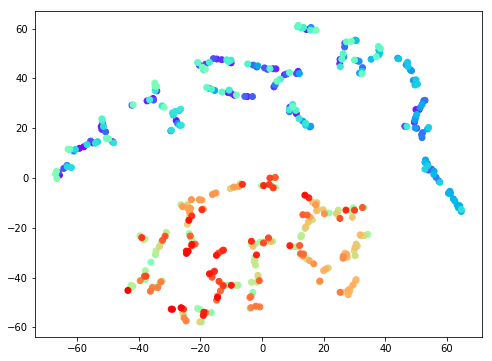

In [95]:
colors = cm.rainbow(np.linspace(0, 1, len(x_axis)))
plt.figure(figsize = (8,6))
plt.scatter(x_axis, y_axis, color=colors)

plt.show()

In [112]:
# data
left= [data[i] for i, t in enumerate(data) if x_axis[i] > 0]
right = [data[i] for i, t in enumerate(data) if x_axis[i] < 0]

In [124]:
x_axis

array([ 40.556023 ,  36.54676  ,  35.953785 ,  40.021255 ,  41.437885 ,
        40.37271  ,  41.00764  ,  41.3638   ,  28.11285  ,  38.338676 ,
        40.243908 ,  40.07445  ,  32.806435 ,  33.713318 ,  39.63824  ,
        40.897522 ,  40.953583 ,  40.466568 ,  40.91934  ,  36.042027 ,
        38.298565 ,  38.834198 ,  40.42346  ,  39.101254 ,  39.40685  ,
        39.977135 ,  38.806988 ,  38.078377 ,  39.89417  ,  40.834095 ,
        38.969357 ,  26.35697  ,  27.360928 ,  31.55673  ,  30.341763 ,
        28.010818 ,  27.696562 ,  30.360804 ,  40.11622  ,  23.345375 ,
        30.80744  ,  38.115696 ,  39.283325 ,  39.75117  ,  38.680405 ,
        31.307072 ,  32.098286 ,  39.407307 ,  13.882454 ,  29.285957 ,
        39.55547  ,  25.052265 ,   9.182245 ,  32.057228 ,  27.616781 ,
        27.31679  ,   4.3536897,  32.1257   ,  39.245476 ,  40.29168  ,
        39.66364  ,  40.424656 ,  34.71026  ,  30.926311 ,  27.340134 ,
        30.091625 ,  33.49298  ,  30.883331 ,  36.16069  ,  30.3

In [13]:

data

[{'index': 0,
  'endIndex': 27648,
  'point': [0.6943362951278687, 0.21766828000545502]},
 {'index': 27648,
  'endIndex': 77824,
  'point': [0.9097703695297241, 0.2348366528749466]},
 {'index': 77824,
  'endIndex': 112128,
  'point': [0.9791333675384521, 0.26567089557647705]},
 {'index': 112128,
  'endIndex': 172544,
  'point': [0.8358666896820068, 0.19333398342132568]},
 {'index': 172544,
  'endIndex': 217088,
  'point': [0.8843101859092712, 0.22691777348518372]},
 {'index': 217088,
  'endIndex': 250880,
  'point': [0.6551300287246704, 0.1447327435016632]},
 {'index': 250880,
  'endIndex': 280064,
  'point': [0.5218175649642944, 0.17776302993297577]},
 {'index': 280064,
  'endIndex': 365568,
  'point': [0.9100050330162048, 0.24695740640163422]},
 {'index': 365568,
  'endIndex': 382976,
  'point': [0.5363278985023499, 0.19083087146282196]},
 {'index': 382976,
  'endIndex': 401920,
  'point': [0.4811927378177643, 0.15886247158050537]},
 {'index': 401920,
  'endIndex': 428032,
  'point':

In [17]:
def sortRule(val):
    return val['point'][0]

def sortTwo(val):
    return val['point'][1]

data_sorted_x = sorted(data, key=sortRule)
data_sorted_y = sorted(data, key=sortTwo)


In [19]:
data_sorted_x

[{'index': 1016832, 'endIndex': 1055744, 'point': [0.0, 0.7395907640457153]},
 {'index': 2317824,
  'endIndex': 2340352,
  'point': [0.005837571807205677, 0.7516642808914185]},
 {'index': 804864,
  'endIndex': 850432,
  'point': [0.014968156814575195, 0.6925347447395325]},
 {'index': 3331584,
  'endIndex': 3375616,
  'point': [0.020411157980561256, 0.8373734951019287]},
 {'index': 2131456,
  'endIndex': 2176512,
  'point': [0.02084660716354847, 0.7533334493637085]},
 {'index': 3104256,
  'endIndex': 3122688,
  'point': [0.021619120612740517, 0.831511378288269]},
 {'index': 5217280,
  'endIndex': 5247488,
  'point': [0.021664828062057495, 0.6910520792007446]},
 {'index': 3313152,
  'endIndex': 3331584,
  'point': [0.025110477581620216, 0.7452316880226135]},
 {'index': 2298368,
  'endIndex': 2317824,
  'point': [0.026121264323592186, 0.7721803784370422]},
 {'index': 3569152,
  'endIndex': 3622912,
  'point': [0.026540031656622887, 0.8514015674591064]},
 {'index': 2895872,
  'endIndex': 2

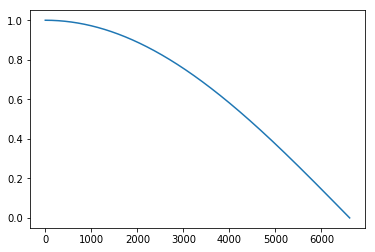

In [107]:
fadeinlen = int(np.floor(0.15 * 44100))
fadein = np.linspace(0, 1, fadeinlen)
pi = 3.1415926
fadein = np.cos(fadein * pi/2)
plt.plot(fadein)

In [108]:

sortedAudioX = []
fadeout = np.asarray(np.zeros(fadeinlen))
np.append(y, fadeout)
for i, sample in enumerate(data_sorted_x):
    audioSampleX = y[sample['index']:sample['endIndex']].copy()
    if (i != 0):
        for j in range(0, fadeinlen):
            sortedAudioX[-j-1] = sortedAudioX[-j-1] + y[sample['index']-j-1]*fadein[j]
            audioSampleX[-j-1] = audioSampleX[-j-1]*fadein[j]
#             audioSampleX[j] = audioSampleX[j] + fadeout[j]
#             fadeout[j] = y[sample['endIndex']+j]*fadein[j]
    sortedAudioX.extend(audioSampleX)
    
sortedAudioX = np.asarray(sortedAudioX)

sortedAudioY = []
fadeout = np.asarray(np.zeros(fadeinlen))
for i, sample in enumerate(data_sorted_y):
    audioSampleY = y[sample['index']:sample['endIndex']].copy()
    if (i != 0):
        for j in range(0, fadeinlen):
            sortedAudioY[-j-1] = sortedAudioY[-j-1] + y[sample['index']-j-1]*fadein[j]
            audioSampleY[-j-1] = audioSampleY[-j-1]*fadein[j]
#             audioSampleY[j] = audioSampleY[j] + fadeout[j]
#             fadeout[j] = y[sample['endIndex']+j]*fadein[j]
    sortedAudioY.extend(audioSampleY)
sortedAudioY = np.asarray(sortedAudioY)

In [83]:
fadeout

array([-6.74381619e-04, -4.94844674e-04, -1.60634209e-04, ...,
        4.12423431e-06,  1.92401687e-06,  2.01516837e-10])

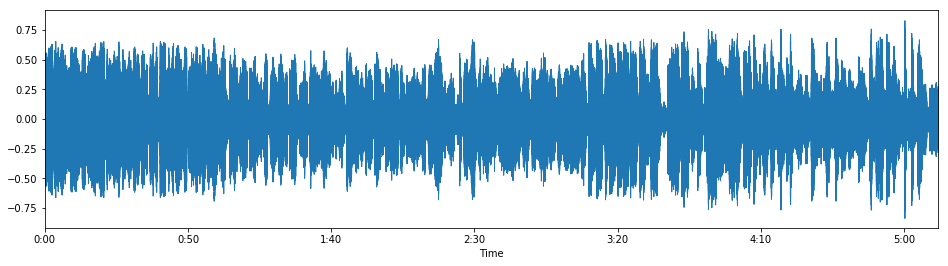

In [24]:
plt.figure(figsize=(16,4))
plt.subplot(1, 1, 1)
librosa.display.waveplot(sortedAudioX, sr=sr)

In [53]:
sortedAudio

[-0.113879204,
 -0.09635646,
 -0.053441044,
 -0.0078731645,
 0.04014782,
 0.06382137,
 0.07127889,
 0.07315172,
 0.08816066,
 0.12949835,
 0.19012369,
 0.26488018,
 0.3517335,
 0.4105923,
 0.41721028,
 0.39539495,
 0.34921956,
 0.3112198,
 0.3079766,
 0.3297355,
 0.36582372,
 0.39349997,
 0.40469688,
 0.40404966,
 0.3895044,
 0.398733,
 0.43108812,
 0.48035067,
 0.5281696,
 0.56214666,
 0.578426,
 0.5603579,
 0.53228384,
 0.4871523,
 0.46102464,
 0.4448067,
 0.4168592,
 0.3799045,
 0.33725202,
 0.28759637,
 0.22829966,
 0.18066604,
 0.124619134,
 0.09020497,
 0.07913221,
 0.08506555,
 0.11598446,
 0.15247034,
 0.17771809,
 0.19303124,
 0.20801163,
 0.20566106,
 0.20098065,
 0.1835794,
 0.14674188,
 0.11331075,
 0.06923296,
 0.032559823,
 0.024273533,
 0.029101694,
 0.059523687,
 0.10810879,
 0.12825978,
 0.120375946,
 0.104803704,
 0.09356627,
 0.0853288,
 0.0740336,
 0.05330648,
 0.029291904,
 0.004989542,
 -0.014803198,
 -0.005222686,
 0.036343895,
 0.082027264,
 0.103181906,
 0.1072

In [109]:
librosa.output.write_wav('./debussyx6fadeout.wav', sortedAudioX, sr)
librosa.output.write_wav('./debussyy6fadeout.wav', sortedAudioY, sr)

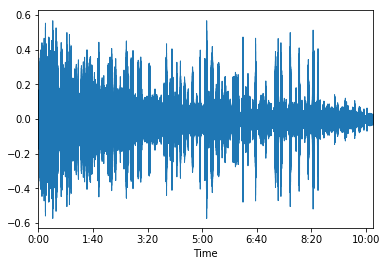

In [99]:
librosa.display.waveplot(sortedAudioX, sr=sr)

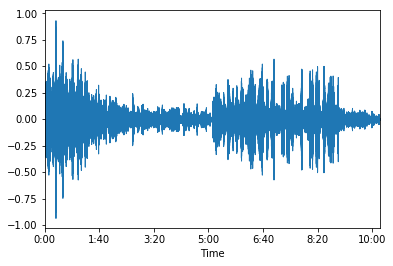

In [100]:
librosa.display.waveplot(sortedAudioY, sr=sr)